In [1]:
import itertools

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load(file):
    
    import pandas as pd
    import ast
    df = pd.read_csv(file)
    
    # convert the column values from literal string to dictionary
    df['ltiFeatures'] = df['ltiFeatures'].apply(ast.literal_eval)
    df['stiFeatures'] = df['stiFeatures'].apply(ast.literal_eval)

    return df

# load all the data
training = load("training.csv")
validation = load("validation.csv")



In [3]:
import pandas as pd
interest_topics = pd.read_csv("interest_topics.csv")


In [4]:
# inspect the data
print(interest_topics.head())

print(training.head())

print(validation.head())

   topic_id                topic_name
0         3     /Arts & Entertainment
1         5  /Computers & Electronics
2         7                  /Finance
3         8                    /Games
4        11            /Home & Garden
   userID  inAudience                                        ltiFeatures  \
0       1        True  {'45': 0.020536141517834786, '47': 0.003117529...   
1       2        True  {'45': 0.001158253110658664, '592': 0.01546380...   
2       3        True  {'908': 0.002470851264264668, '590': 0.0021402...   
3       4        True  {'1187': 0.001127974558171163, '1780': 0.00117...   
4       5        True  {'907': 0.025339209040149392, '1187': 0.006020...   

                                         stiFeatures  
0                                                 {}  
1                                                 {}  
2                                                 {}  
3                                                 {}  
4  {'907': 0.10445132121076425, '908': 0

In [5]:
Id_to_topic= {}
topic_to_newID= {}
index= 0

print(len(interest_topics))
for row in interest_topics.iterrows():
    Id= row[1][0]
    Id=str(Id)
    topic= row[1][1]
    
    topic= topic.split('/')[1]
    Id_to_topic[Id]= topic
    if topic not in topic_to_newID.keys():
        topic_to_newID[topic]= index
        index+=1

print(Id_to_topic)
print(topic_to_newID)
    

1411
{'3': 'Arts & Entertainment', '5': 'Computers & Electronics', '7': 'Finance', '8': 'Games', '11': 'Home & Garden', '12': 'Business & Industrial', '13': 'Internet & Telecom', '14': 'People & Society', '16': 'News', '18': 'Shopping', '19': 'Law & Government', '20': 'Sports', '22': 'Books & Literature', '23': 'Arts & Entertainment', '24': 'Arts & Entertainment', '25': 'Business & Industrial', '28': 'Business & Industrial', '29': 'Real Estate', '30': 'Computers & Electronics', '31': 'Computers & Electronics', '32': 'Computers & Electronics', '33': 'Arts & Entertainment', '34': 'Arts & Entertainment', '35': 'Arts & Entertainment', '36': 'Arts & Entertainment', '37': 'Finance', '38': 'Finance', '39': 'Games', '41': 'Games', '42': 'Arts & Entertainment', '43': 'Online Communities', '44': 'Beauty & Fitness', '45': 'Health', '46': 'Business & Industrial', '47': 'Autos & Vehicles', '48': 'Business & Industrial', '49': 'Business & Industrial', '50': 'Business & Industrial', '53': 'Internet &

In [7]:
def model_LTIOnly(file):
    
    columns= ['']*26

    for key, val in topic_to_newID.items():
        columns[val]= key+ ' LTI'
      
    columns[25]= 'Convert'
    
    new_user2= pd.DataFrame()
    data=[]
    i= 0

    for row in file.iterrows():
        LTI = np.zeros(25)
        
        for key, val in row[1][2].items():
            if key in Id_to_topic:
                topic= Id_to_topic[key]
                index= topic_to_newID[topic]
            
            else:
                continue
            LTI[index]+= val
        
        LTI=LTI/np.sum(LTI) 
    
    
        new_entry= [entry for entry in LTI]
        new_entry.append(int(row[1][1]))
        data.append(new_entry)
        i+=1
        if i>1000:
        
            new_data= pd.DataFrame(data, columns = columns)
            new_user2= new_user2.append(new_data)
            data=[]
            i=0
        
    new_data= pd.DataFrame(data, columns = columns)
    new_user2= new_user2.append(new_data)

    return new_user2

In [9]:
def model_noSTIData_LTIfeature(file):
    columns= ['']*26

    for key, val in topic_to_newID.items():
        columns[val]= key+ ' LTI'
      
    columns[25]= 'Convert'
    
    new_user2= pd.DataFrame()
    data=[]
    i= 0

    for row in file.iterrows():
        LTI = np.zeros(25)
    
        if not row[1][3]:
            for key, val in row[1][2].items():
                if key in Id_to_topic:
                    topic= Id_to_topic[key]
                    index= topic_to_newID[topic]
            
                else:
                    continue
                LTI[index]+= val
        
            LTI=LTI/np.sum(LTI) 
    
    
        new_entry= [entry for entry in LTI]
        new_entry.append(int(row[1][1]))
        data.append(new_entry)
        i+=1
        if i>1000:
        
            new_data= pd.DataFrame(data, columns = columns)
            new_user2= new_user2.append(new_data)
            data=[]
            i=0
        
    new_data= pd.DataFrame(data, columns = columns)
    new_user2= new_user2.append(new_data)

    return new_user2

In [49]:
def model_STIData_bothFeat(file):
    columns_3= ['']*51

    for key, val in topic_to_newID.items():
        columns_3[val]= key+ ' LTI'
        columns_3[val+25]= key+' STI'
    
    
    columns_3[50]= 'Convert'
    
    new_user3= pd.DataFrame()
    data=[]
    i= 0

    for row in training.iterrows():
        LTI = np.zeros(25)
        STI = np.zeros(25)
    
        if row[1][3]:
        
            for key, val in row[1][2].items():
                if key in Id_to_topic:
                    topic= Id_to_topic[key]
                    index= topic_to_newID[topic]
            
                else:
                    continue
                LTI[index]+= val
        
            LTI=LTI/np.sum(LTI) 
    
            for key, val in row[1][3].items():
                if key in Id_to_topic:
                    topic= Id_to_topic[key]
                    index= topic_to_newID[topic]
            
                else:
                    continue
    
                STI[index]+=val
            STI=STI/np.sum(STI)
        
        else:
            continue
        new_entry= [entry for entry in LTI]
        for entry in STI:
            new_entry.append(entry)
        new_entry.append(int(row[1][1]))
        data.append(new_entry)
        i+=1
        if i>1000:
        
            new_data= pd.DataFrame(data, columns = columns_3)
            new_user3= new_user3.append(new_data)
            data=[]
            i=0
        
    new_data= pd.DataFrame(data, columns = columns_3)
    new_user3= new_user3.append(new_data)
    
    return new_user3

In [50]:
def Split(train, test):
    X_train = train.iloc[:, :-1]
    y_train = train.iloc[:, -1]
    X_test = test.iloc[:, :-1]
    y_test = test.iloc[:, -1]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    cols = X_train.columns
    return X_train, y_train, X_test, y_test, cols

In [51]:
def underSamp(X_train, y_train):
    usamp = RandomUnderSampler()
    us_X_train, us_y_train=usamp.fit_sample(X_train, y_train)
    us_X_train = pd.DataFrame(data=us_X_train,columns=cols)
    return us_X_train, us_y_train

In [52]:
def RunAlgRF(us_X_train, us_y_train, X_test, y_test):
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(us_X_train, us_y_train)
    scores = cross_val_score(clf, us_X_train, us_y_train, cv=3, scoring='accuracy')
    print('Training accuracy= '+str(scores.mean()))
    print('Training standard deviation= '+ str(np.std(scores)))
    #clf.score(X_test, y_test)
    print('Testing accuracy= '+str(clf.score(X_test, y_test)))
    return clf

In [53]:
def RunAlgXG(us_X_train, us_y_train, X_test, y_test):
    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return clf

In [54]:
def RunAlgSVM(us_X_train, us_y_train, X_test, y_test):
    clf = SVC(gamma = 'auto')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return clf

In [55]:
def var_import(cols, clf):
    importance = pd.DataFrame({'feature': list(cols), 'feature_importance': [round(i, 4) for i in list(clf.feature_importances_)]})
    importance = importance.sort_values(by=['feature_importance'], ascending=False)
    importance = importance.set_index('feature')
    return importance

In [56]:
def plot_importance(importance):
    plt.rcParams['figure.figsize']= [16, 10]
    ax = plt.bar(importance.index, importance['feature_importance'])
    plt.xticks( rotation='vertical')
    plt.title('Variable Feature Importance')
    plt.xlabel('Variable')
    plt.ylabel('Feature Importance')
    plt.show()

In [57]:
def plot_confusion(x, y, clf):
    names = ['No Conversion', "Conversion"]
    conf = confusion_matrix(y, pd.DataFrame(clf.predict(x)))
    conf = conf.astype('float')/ conf.sum(axis=1)[:, np.newaxis] 
    plt.imshow(conf, interpolation='nearest', cmap=plt.get_cmap('Greens')) 
    marks = np.arange(len(names))
    for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
        plt.text(j, i, "{}%".format(round(conf[i, j]*100,2)), horizontalalignment="center") 
    plt.xticks(marks, names)
    plt.yticks(marks, names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [58]:
def ROC_AUC(x, y, clf):
    AUC = roc_auc_score(y, clf.predict(x))
    FPR, TPR, thresh = roc_curve(y, clf.predict_proba(x)[:,1]) 
    plt.plot(FPR, TPR, label='Area Under Curve = %0.2f' % AUC) 
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

Accuracy: 99.23%


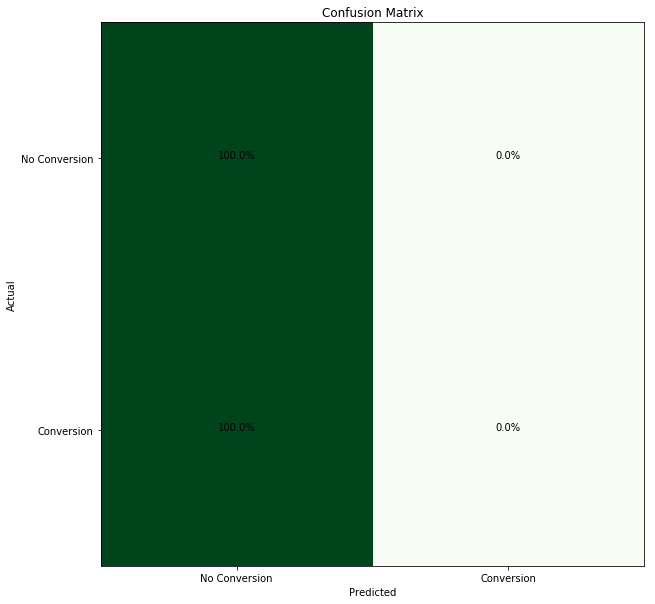

In [59]:
train= model_LTIOnly(training)
test= model_LTIOnly(validation)
X_train, y_train, X_test, y_test, cols= Split(train, test)
us_X, us_y= underSamp(X_train, y_train)

clf= RunAlgSVM(us_X, us_y, X_test, y_test)
plot_confusion(X_test, y_test, clf)

Accuracy: 99.23%


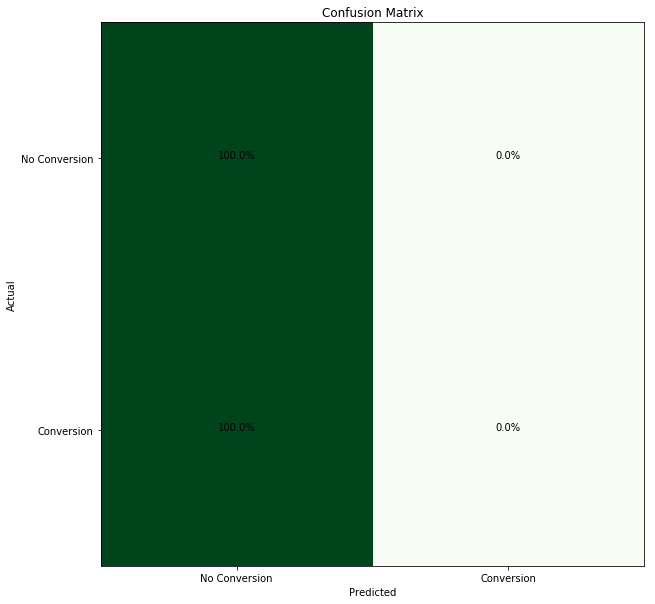

In [60]:
train= model_LTIOnly(training)
test= model_LTIOnly(validation)
X_train, y_train, X_test, y_test, cols= Split(train, test)
us_X, us_y= underSamp(X_train, y_train)

clf= RunAlgXG(us_X, us_y, X_test, y_test)
plot_confusion(X_test, y_test, clf)

Training accuracy= 0.6371924134231788
Training standard deviation= 0.010351983194491073
Testing accuracy= 0.7215403459654035


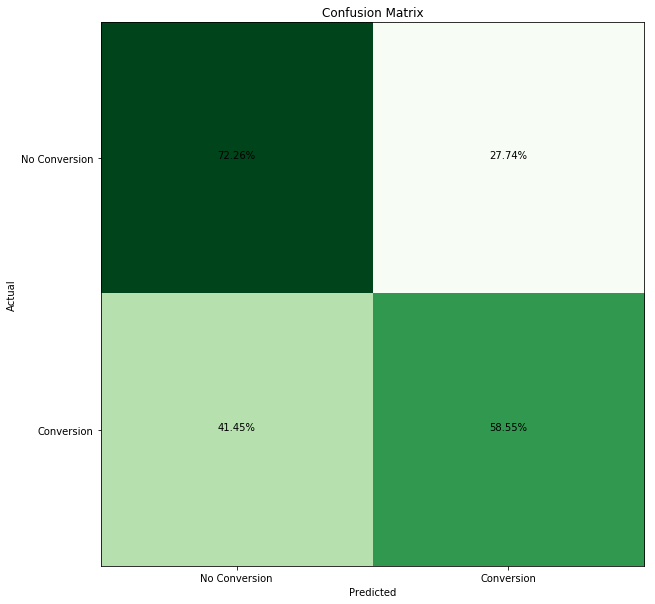

In [61]:
train= model_LTIOnly(training)
test= model_LTIOnly(validation)

X_train, y_train, X_test, y_test, cols= Split(train, test)
us_X, us_y= underSamp(X_train, y_train)
clf= RunAlgRF(us_X, us_y, X_test, y_test)

plot_confusion(X_test, y_test, clf)



In [62]:
print(us_X.shape)
print(us_y.shape)

(2930, 25)
(2930,)


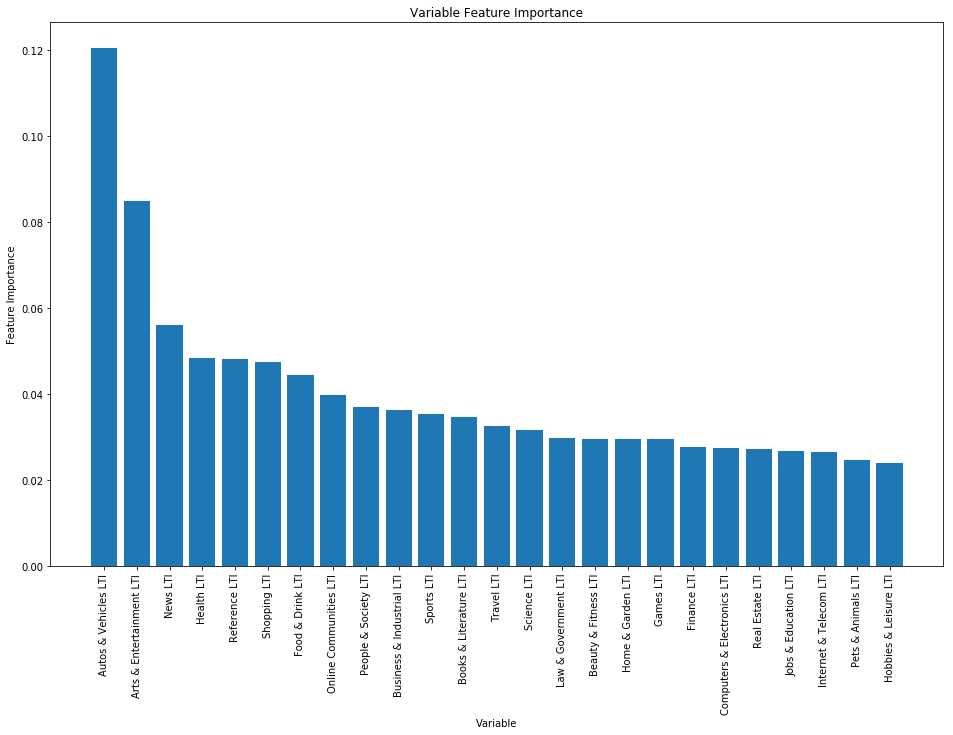

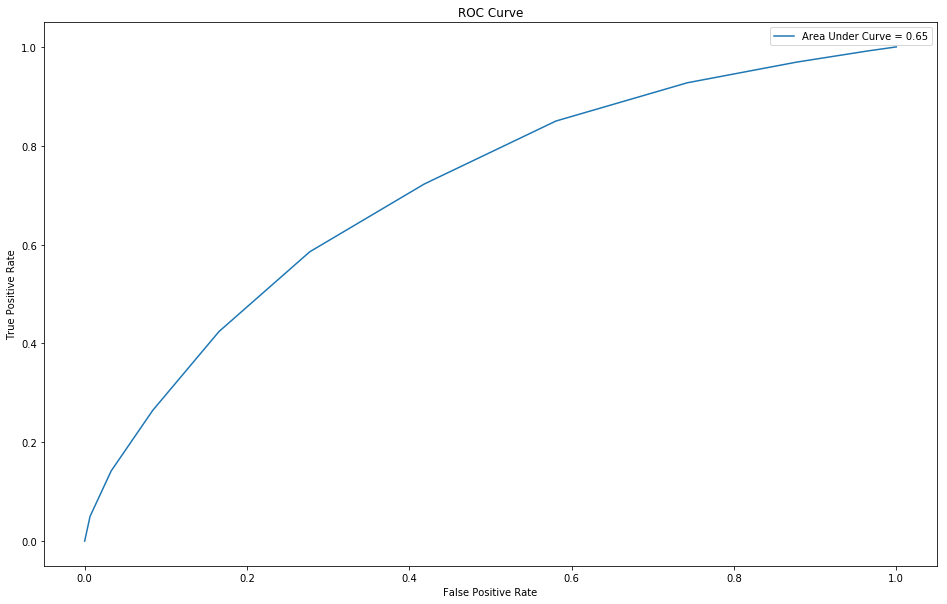

In [63]:
importance= var_import(cols, clf)
plot_importance(importance)
ROC_AUC(X_test, y_test, clf)

Training accuracy= 0.6501673012576439
Training standard deviation= 0.011694220008381936
Testing accuracy= 0.7425142723989281


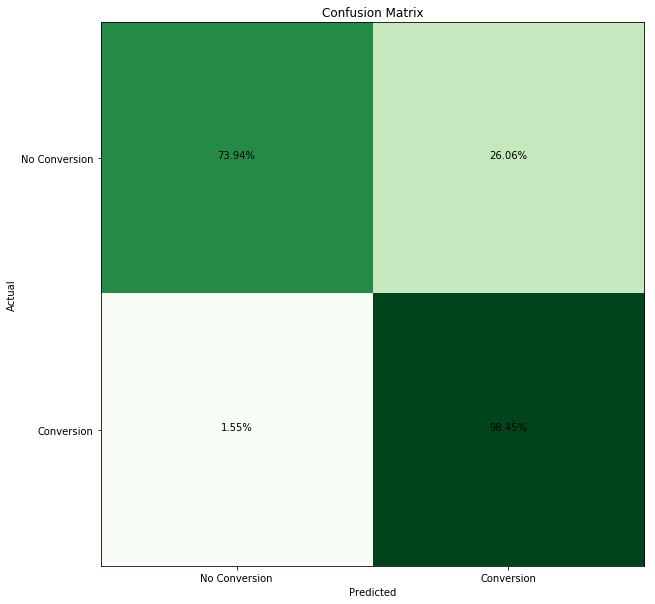

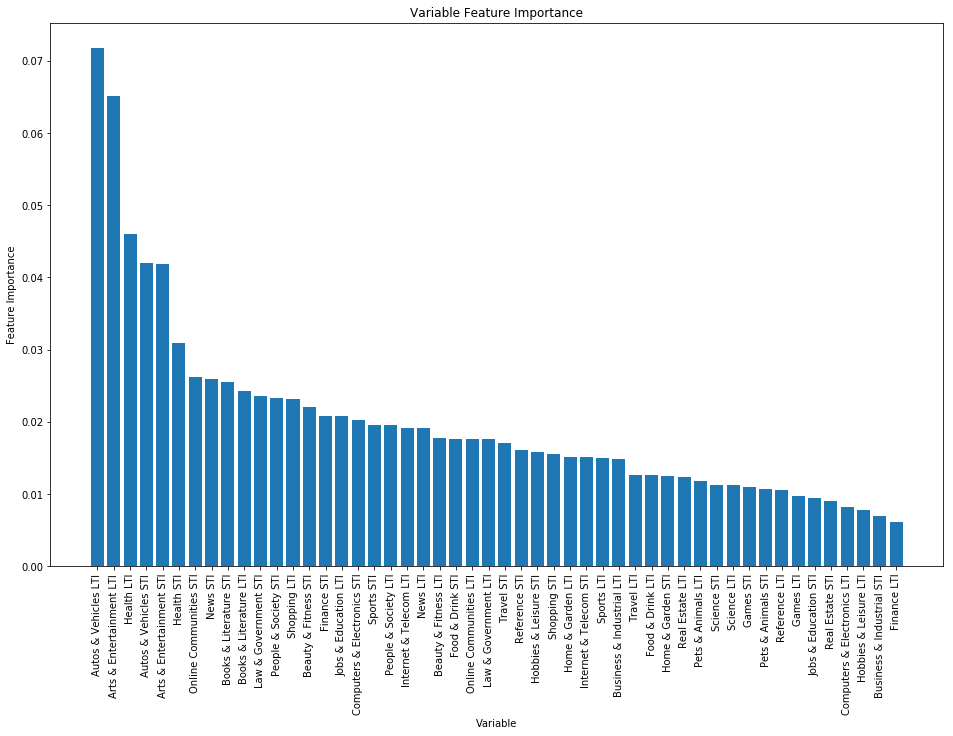

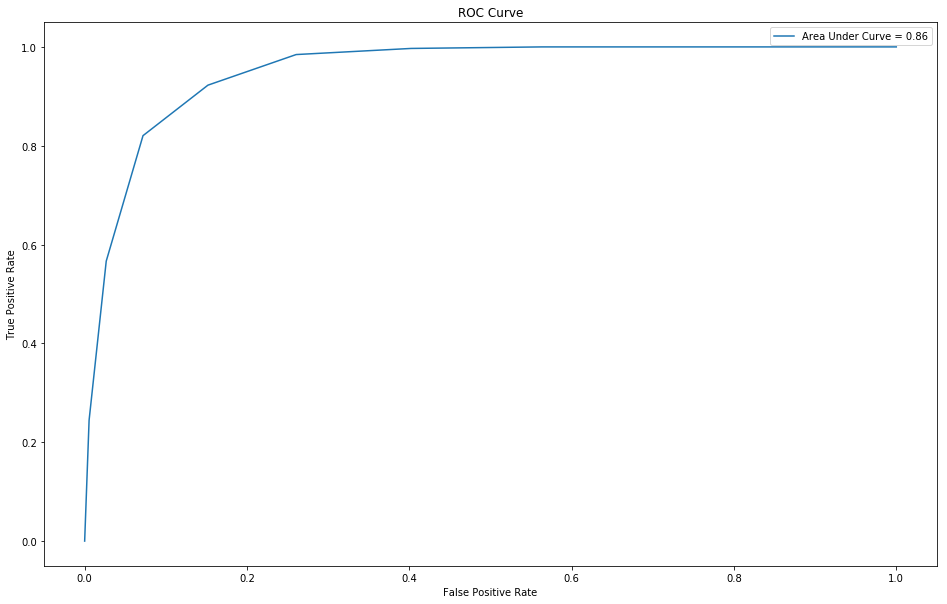

In [76]:
train= model_STIData_bothFeat(training)
test= model_STIData_bothFeat(validation)

X_train, y_train, X_test, y_test, cols= Split(train, test)
us_X, us_y= underSamp(X_train, y_train)

clf= RunAlgRF(us_X, us_y, X_test, y_test)

plot_confusion(X_test, y_test, clf)
importance= var_import(cols, clf)
plot_importance(importance)
ROC_AUC(X_test, y_test, clf)

Nested Cross Validation

In [65]:
def RandomCV(X_train, y_train):
    from sklearn.model_selection import RandomizedSearchCV
    
    n_estimators = [int(x) for x in np.linspace(start=10, stop= 200, num=10)]
    max_depth = [int(x) for x in np.linspace(10, 110, num=5)]
    max_depth.append(None)
    min_samples_split= [2, 5, 10]
    min_samples_leaf= [1, 2, 4]
    bootstrap= [True, False]
    
    random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    
    clf= RandomForestClassifier()
    clf_random= RandomizedSearchCV(estimator = clf, param_distributions=random_grid, 
                n_iter=20, scoring='roc_auc', cv=3)
    
    clf_random.fit(X_train, y_train)
    
    print(clf_random.best_params_)
    
    return clf_random.best_estimator_
    

In [66]:
train= model_noSTIData_LTIfeature(training)
test= model_noSTIData_LTIfeature(validation)

X_train, y_train, X_test, y_test, cols= Split(train, test)
us_X, us_y= underSamp(X_train, y_train)


In [67]:
best_random= RandomCV(us_X, us_y)
scores = cross_val_score(best_random, us_X, us_y, cv=3, scoring='accuracy')
print('Training accuracy= '+str(scores.mean()))
print('Training standard deviation= '+ str(np.std(scores)))

clf = RandomForestClassifier(n_estimators=10)
clf.fit(us_X, us_y)

scores = cross_val_score(clf, us_X, us_y, cv=3, scoring='accuracy')
print('Training accuracy= '+str(scores.mean()))
print('Training standard deviation= '+ str(np.std(scores)))


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': True}
Training accuracy= 0.6399288444131549
Training standard deviation= 0.0036572327976603126
Training accuracy= 0.6153477600098339
Training standard deviation= 0.011109207991597064


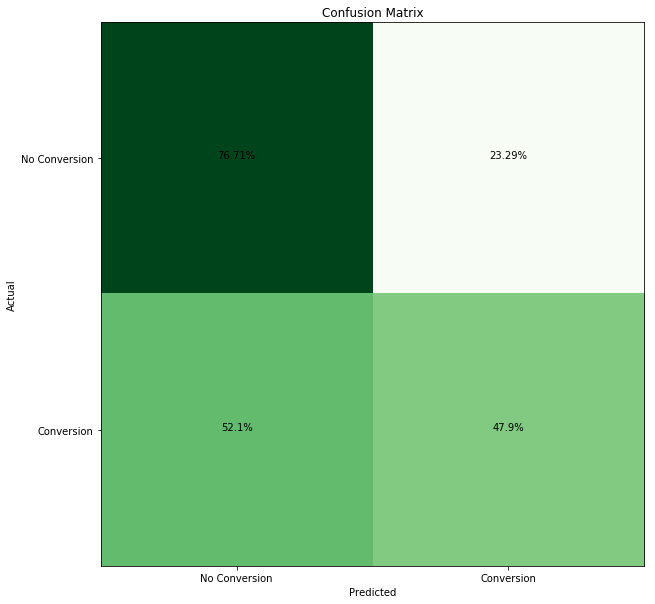

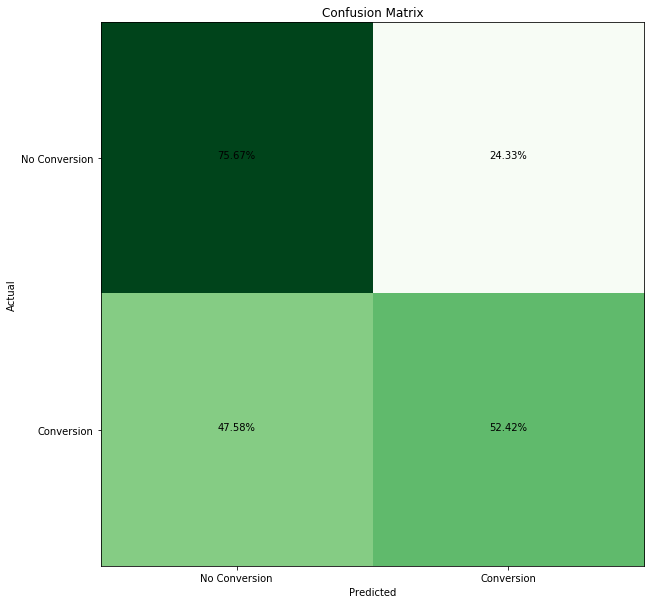

In [68]:
plot_confusion(X_test, y_test, clf)
plot_confusion(X_test, y_test, best_random)

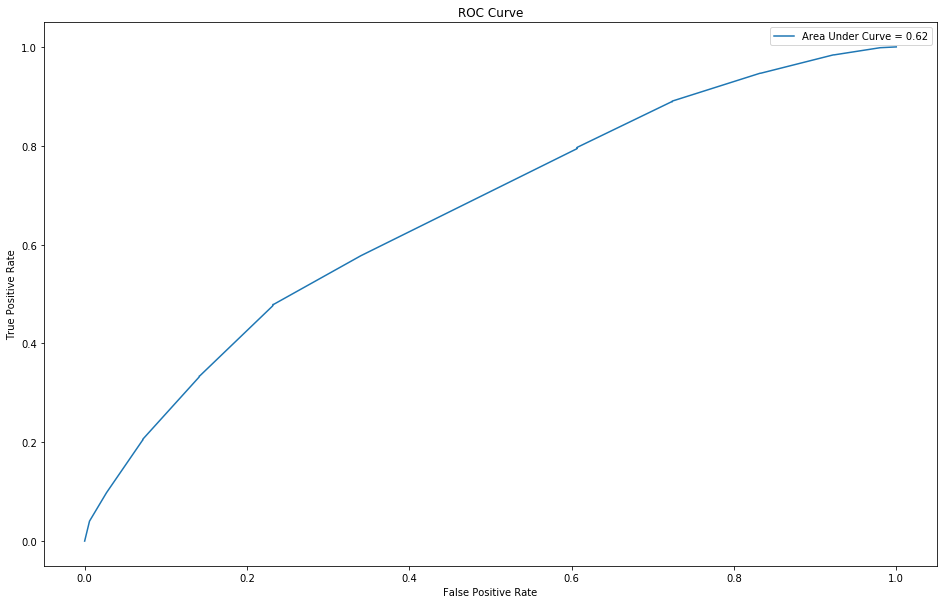

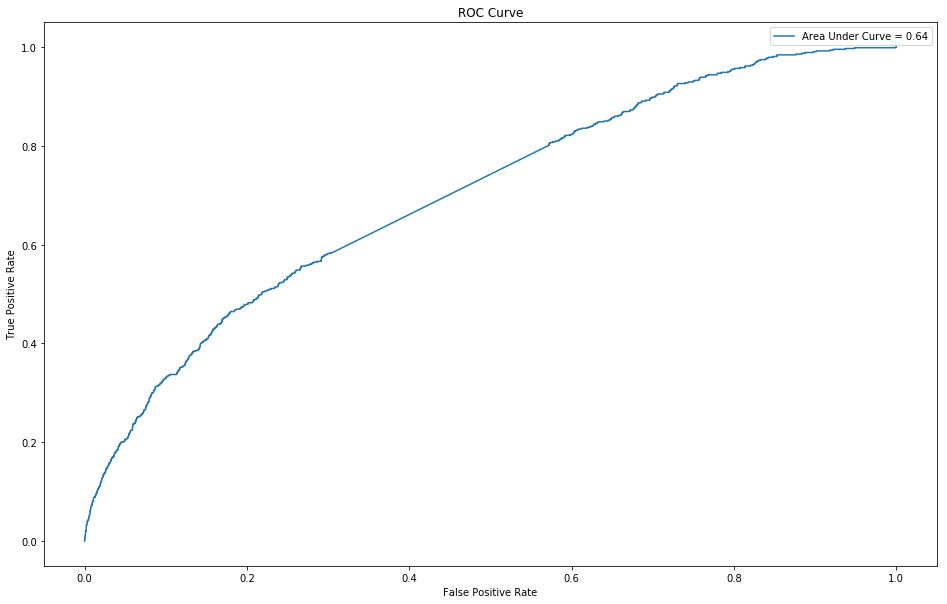

In [69]:
ROC_AUC(X_test, y_test, clf)
ROC_AUC(X_test, y_test, best_random)

In [70]:
train= model_STIData_bothFeat(training)
test= model_STIData_bothFeat(validation)

X_train, y_train, X_test, y_test, cols= Split(train, test)
us_X, us_y= underSamp(X_train, y_train)

In [71]:
best_random= RandomCV(us_X, us_y)
scores = cross_val_score(best_random, us_X, us_y, cv=3, scoring='accuracy')
print('Training accuracy= '+str(scores.mean()))
print('Training standard deviation= '+ str(np.std(scores)))

clf = RandomForestClassifier(n_estimators=10)
clf.fit(us_X, us_y)
scores = cross_val_score(clf, us_X, us_y, cv=3, scoring='accuracy')
print('Training accuracy= '+str(scores.mean()))
print('Training standard deviation= '+ str(np.std(scores)))


{'n_estimators': 178, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 60, 'bootstrap': True}
Training accuracy= 0.6980789200415369
Training standard deviation= 0.026920424887044686
Training accuracy= 0.640850351909542
Training standard deviation= 0.01195152915537518


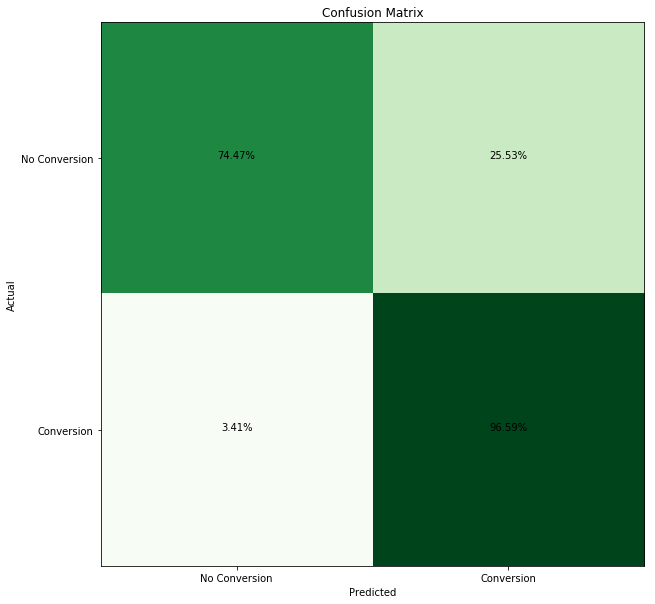

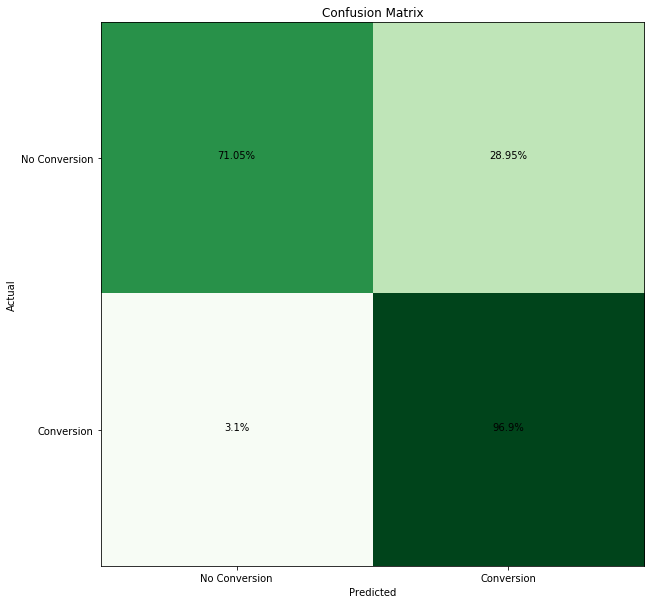

In [72]:
plot_confusion(X_test, y_test, clf)
plot_confusion(X_test, y_test, best_random)

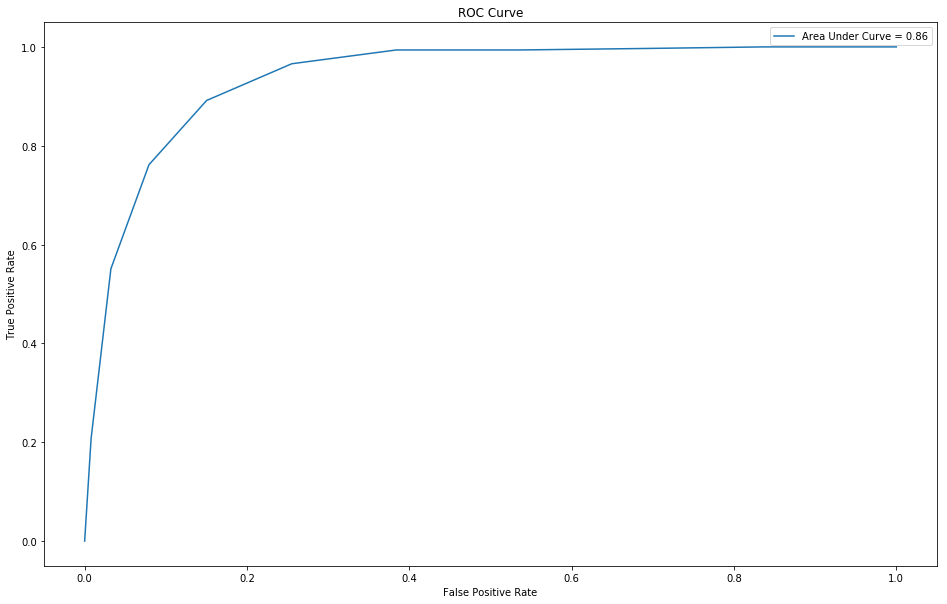

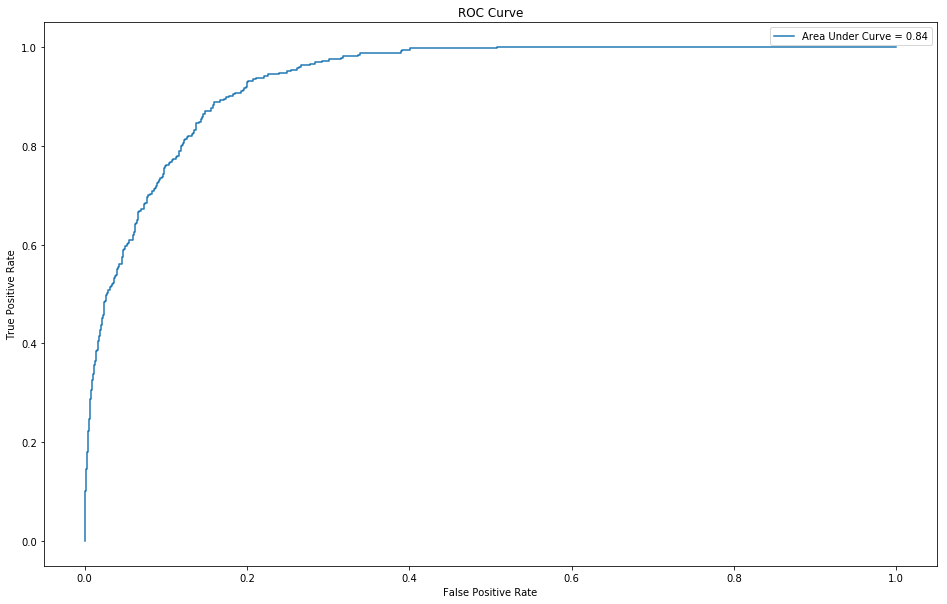

In [73]:
ROC_AUC(X_test, y_test, clf)
ROC_AUC(X_test, y_test, best_random)

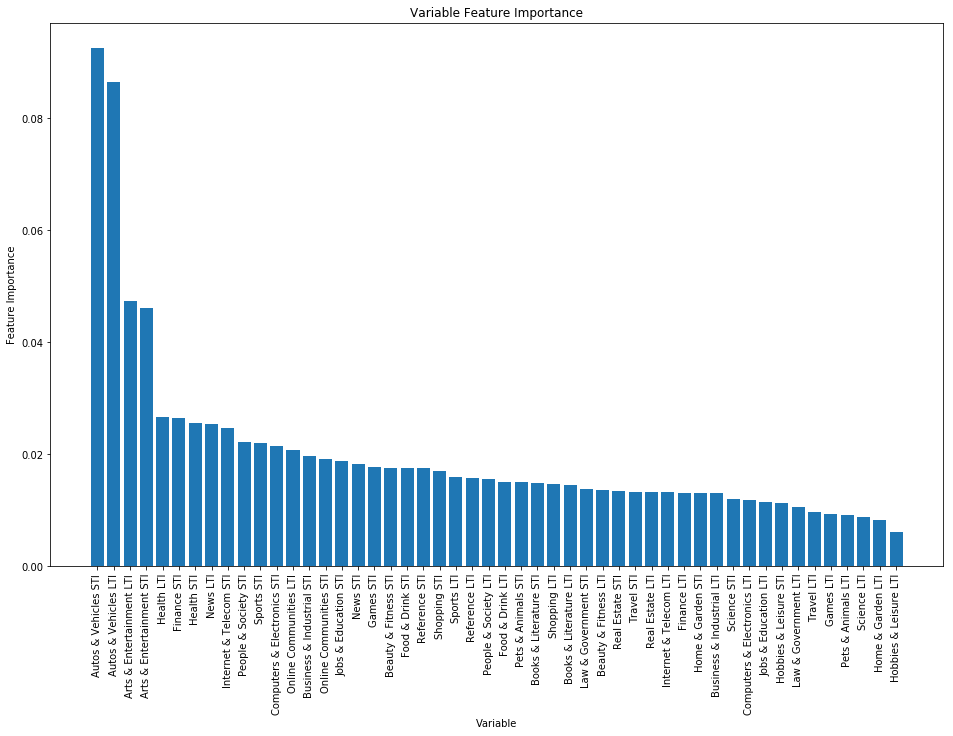

,feature_importance
feature,
Autos & Vehicles STI,0.0925
Autos & Vehicles LTI,0.0865
Arts & Entertainment LTI,0.0473
Arts & Entertainment STI,0.0461
Health LTI,0.0267
Finance STI,0.0265
Health STI,0.0256
News LTI,0.0254
Internet & Telecom STI,0.0246


In [74]:
impor= var_import(cols, best_random)
plot_importance(impor)
impor

In [75]:
impor


,feature_importance
feature,
Autos & Vehicles STI,0.0925
Autos & Vehicles LTI,0.0865
Arts & Entertainment LTI,0.0473
Arts & Entertainment STI,0.0461
Health LTI,0.0267
Finance STI,0.0265
Health STI,0.0256
News LTI,0.0254
Internet & Telecom STI,0.0246


In [ ]:
export_csv = impor.to_csv (r'C:\Users\danielsprague\Desktop\VI.csv',index=True,header=True)